- 2019/08/30 - leptonJet energy distribution for MC of backgrounds and signals

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import awkward
from FireHydrant.Tools.metfilter import MetFilters

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

bkgdatasets_=json.load(open('../Samples/backgrounds_nonempty.json'))

In [10]:
class leptonJetEnergyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        eta_axis = hist.Bin('eta', '$\eta$', 100, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 100, -np.pi, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            'energy': hist.Hist('Energy', dataset_axis, eta_axis, phi_axis),
            'multiplicity': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
            'leading': hist.Hist('Leading leptonJet', dataset_axis, eta_axis, phi_axis),
            'electrontype': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
            'mutype': hist.Hist('Multiplicity', dataset_axis, eta_axis, phi_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset=df['dataset']
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        ljnmus = ((ljdautype==3)|(ljdautype==8)).astype(int).sum()
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        ljnmus = ljnmus[metfiltermask]
        
        output['energy'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                             phi=leptonjets.phi.flatten(),
                             weight=leptonjets.p4.energy.flatten())
        output['multiplicity'].fill(dataset=dataset, eta=leptonjets.eta.flatten(),
                                   phi=leptonjets.phi.flatten())
        
#         leadidx = leptonjets.pt.argmax()
#         output['leading'].fill(dataset=dataset, eta=leptonjets[leadidx].eta.flatten(),
#                               phi=leptonjets[leadidx].phi.flatten())
        
        electrontypemask = ljnmus<2
        output['electrontype'].fill(dataset=dataset, eta=leptonjets[electrontypemask].eta.flatten(),
                                    phi=leptonjets[electrontypemask].phi.flatten())
        output['mutype'].fill(dataset=dataset, eta=leptonjets[~electrontypemask].eta.flatten(),
                             phi=leptonjets[~electrontypemask].phi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [11]:
datasets = bkgdatasets_['QCD']
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  
                                 )

Processing: 100%|██████████| 1223/1223 [01:02<00:00, 19.43items/s]


#### counts

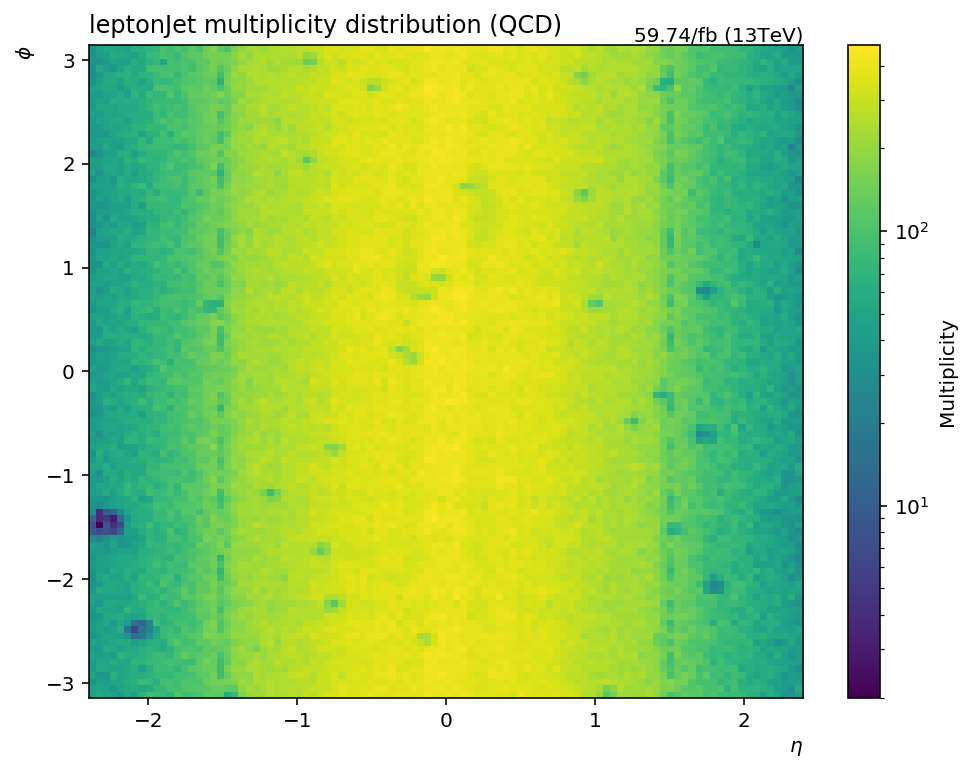

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['multiplicity'].integrate('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('leptonJet multiplicity distribution (QCD)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

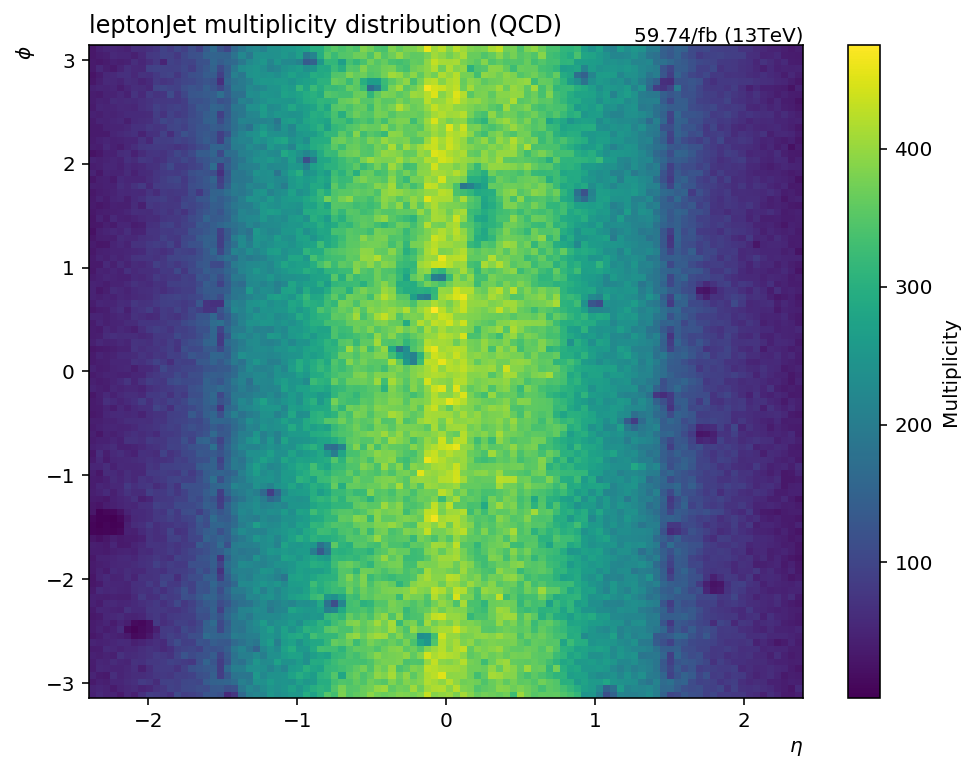

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['multiplicity'].integrate('dataset'), xaxis='eta', ax=ax,)

ax.set_title('leptonJet multiplicity distribution (QCD)', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [15]:
datasets = bkgdatasets_['DYJetsToLL']
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonJetEnergyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1360/1360 [01:05<00:00, 22.04items/s]


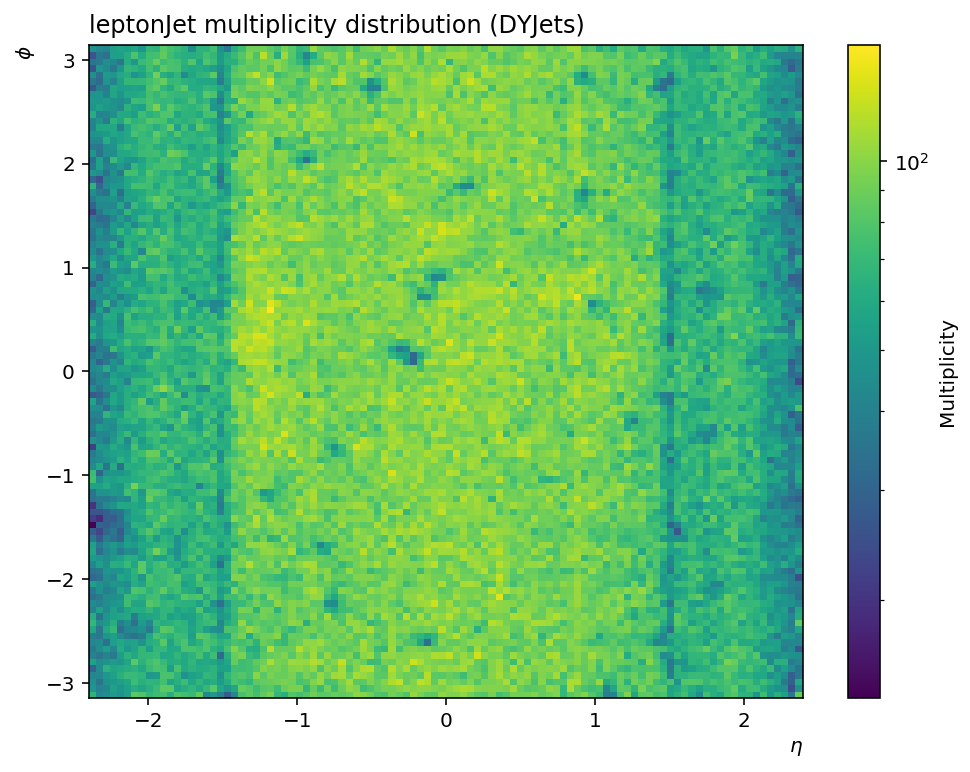

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot2d(output['multiplicity'].integrate('dataset'), xaxis='eta', ax=ax, patch_opts=dict(norm=LogNorm()))

ax.set_title('leptonJet multiplicity distribution (DYJets)', x=0.0, ha="left")
# ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");